In [1]:
#main
import pandas as pd
import numpy as np
import math
import sklearn

#graphic
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

#specific
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.utils import resample
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from random import randint
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score

#options
pd.set_option('display.max_columns', None) #show all the columns
pd.set_option('display.max_rows', None) #show all the rows


In [2]:
# Load data

In [3]:
m1 = pd.read_csv('cleaned_measurements.csv')


In [4]:
m1.head()

,Unnamed: 0,distance,consume,speed,temp_inside,temp_outside,gas_type,ac,rain,sun,temp_difference
0,0,28.0,5.0,26,21.5,12,E10,0,0,0,9.5
1,1,12.0,4.2,30,21.5,13,E10,0,0,0,8.5
2,2,11.2,5.5,38,21.5,15,E10,0,0,0,6.5
3,3,12.9,3.9,36,21.5,14,E10,0,0,0,7.5
4,4,18.5,4.5,46,21.5,15,E10,0,0,0,6.5


In [5]:
m1.dtypes

Unnamed: 0           int64
distance           float64
consume            float64
speed                int64
temp_inside        float64
temp_outside         int64
gas_type            object
ac                   int64
rain                 int64
sun                  int64
temp_difference    float64
dtype: object

In [6]:
m1.isna().sum().sum()

0

Note from kaggle.com: In the file, you will find the displayed distance (km); the consume (L/100km); the average speed (km/h), the temperature i had inside (°C), the temperature outside (°C), anything special that happened, if it was raining, if the air condition was on, if it was sunny enough that the car felt warm when i started it… and yes - the gas type i was using. I have also two columns saying how much and which gas type I was buying. Careful with those. The numbers don't add exactly up, because I note only the rides that occur under certain conditions: If the car was not cooling down enough to have another independent measure from the one before, i don't note it.

# Pre-model steps

## Check multicollinearity

In [7]:
numericals_df=m1.select_dtypes(np.number)
categoricals_df=m1.select_dtypes(object)


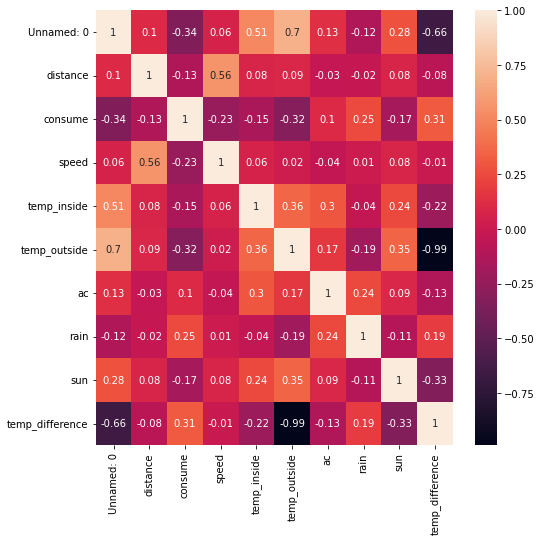

In [8]:
fig, ax = plt.subplots(figsize=(8,8)) #First we have to use plt.subplots to create plot environment.
ax=sns.heatmap(round(numericals_df.corr(),2), annot=True)
plt.show()

## X-y split

In [9]:
X = m1.drop(['Unnamed: 0','consume'], axis=1)
y= m1['consume']

display(y.shape)
display(X.shape)

(388,)

(388, 9)

## Train - test split

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Numerical Categorical Split

In [11]:
X_train_cat = X_train.select_dtypes(include = object)
X_test_cat = X_test.select_dtypes(include = object)
X_train_num = X_train.select_dtypes(include = np.number)
X_test_num = X_test.select_dtypes(include = np.number)

# Modeling

## Scale & Encode

In [12]:
scaler = MinMaxScaler().fit(X_train_num)
encoder = OneHotEncoder().fit(X_train_cat)

In [13]:
def transform(dataframe):
    # This function assumes that you have initialized a scaler and an encoder, based on the training data
    cat = dataframe.select_dtypes(include = object)
    num = dataframe.select_dtypes(include = np.number)

    if not cat.empty:
        cat_transformed = encoder.transform(cat)
        cat_transformed = cat_transformed.toarray()
        cat_new = pd.DataFrame(data = cat_transformed, columns = encoder.get_feature_names_out())
    else: 
        cat_new = cat
    
    if not num.empty:
        num_transformed = scaler.transform(num)
        num_new = pd.DataFrame(data = num_transformed, columns = num.columns)
    else:
        num_new = num
    
    return pd.concat([cat_new, num_new], axis = 1)


In [14]:
X_train = transform(X_train)
X_test = transform(X_test)

In [15]:
X_train.isna().sum().sum()

0

In [16]:
X_train.head()

,gas_type_E10,gas_type_SP98,distance,speed,temp_inside,temp_outside,ac,rain,sun,temp_difference
0,0.0,1.0,0.025605,0.157895,0.384615,0.305556,0.0,0.0,0.0,0.691176
1,1.0,0.0,0.048883,0.342105,0.538462,0.194444,0.0,0.0,0.0,0.838235
2,0.0,1.0,0.068901,0.250000,0.384615,0.305556,0.0,0.0,0.0,0.691176
3,0.0,1.0,0.115922,0.750000,0.307692,0.361111,1.0,1.0,0.0,0.617647
4,0.0,1.0,0.068436,0.421053,0.461538,0.611111,0.0,0.0,0.0,0.382353


## Model selection pipeline

In [17]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [18]:
# building a pipeline to compare the models

model1 = DecisionTreeRegressor() # does not care about the distance. Looks at similarity between the points regardless of the distance between them. We do not need scaling beforehand but it does not harm if you scale
from sklearn.linear_model import LinearRegression # using 'distance' in the model (so the data needs to be scaled beforehand)
model2 = LinearRegression()
from sklearn.neighbors import KNeighborsRegressor # using 'distance' in the model (so the data needs to be scaled beforehand)
model3 = KNeighborsRegressor()
from sklearn.ensemble import RandomForestRegressor
model4=RandomForestRegressor()

model_pipeline = [model1, model2, model3, model4]
model_names = ['Decision Tree Regressor', 'Linear Regression', 'KNN', 'Random Forest Regressor']
scores = {}
for model, model_name in zip(model_pipeline, model_names): #zip allows us to walk through the list
    mean_score = np.mean(cross_val_score(model, X_train, y_train, cv=5)) #using the cross_val_score on (model, X_train, y_train, cv=10)
    scores[model_name] = mean_score
print(scores)

# We can use the result to choose the best performing model

{'Decision Tree Regressor': -0.17773611268851128, 'Linear Regression': 0.06820971641920556, 'KNN': 0.14206743834822586, 'Random Forest Regressor': 0.4478944875789038}


In [19]:
test_scores = {}

for model, model_name in zip(model_pipeline,model_names):
    model.fit(X_train, y_train)
    test_scores[model_name] = model.score(X_test,y_test)
print(test_scores)

{'Decision Tree Regressor': -0.12198168494850559, 'Linear Regression': 0.09686276228792212, 'KNN': 0.0996507640329346, 'Random Forest Regressor': 0.5439821351636367}


In [ ]:
# Random Forest regressor performs the best!

## Metrics

In [20]:
# train r2
predictions = model4.predict(X_train)
r2_score(y_train, predictions)

0.9398626705499445

In [21]:
# test r2

predictions_test = model4.predict(X_test)
r2_score(y_test, predictions_test)

0.5439821351636367

In [22]:
y_test[:10]

271    5.6
46     5.1
167    6.1
42     4.6
349    4.3
181    7.1
153    5.0
33     4.8
116    5.1
148    4.7
Name: consume, dtype: float64

In [23]:
predictions_test[:10]


array([5.309, 5.291, 5.172, 4.532, 4.208, 5.228, 5.117, 4.704, 5.416,
       4.555])

In [24]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt

def scores(model, X, y):
    predictions = model4.predict(X)

    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    mae = mean_absolute_error(y, predictions)
    rmse = sqrt(mse)

    return r2, mse, mae, rmse

In [25]:
def print_metrics(r2, mse, mae, rmse):
    print('Regression model metrics:') 
    print('Mean squared error: ', mse)
    print('Mean absolute error:', mae)
    print('Root mean squared error:', rmse)
    print('r2:', r2)

In [26]:
r2_train, mse_train, mae_train, rmse_train = scores(model4, X_train, y_train)

In [27]:
print_metrics(r2_train, mse_train, mae_train, rmse_train) #train metrics

Regression model metrics:
Mean squared error:  0.06640188074071005
Mean absolute error: 0.1696999615975421
Root mean squared error: 0.25768562385338856
r2: 0.9398626705499445


In [28]:
r2_test, mse_test, mae_test, rmse_test = scores(model4, X_test, y_test)

In [29]:
print_metrics(r2_test, mse_test, mae_test, rmse_test) #test metrics

Regression model metrics:
Mean squared error:  0.413747767059495
Mean absolute error: 0.42076205738705735
Root mean squared error: 0.6432322807971433
r2: 0.5439821351636367


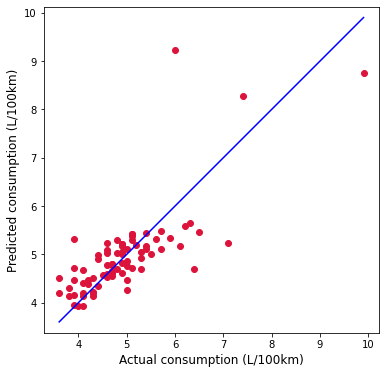

In [34]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, predictions_test, c='crimson')
# plt.yscale('log')
# plt.xscale('log')

p1 = max(max(predictions_test), max(y_test))
p2 = min(min(predictions_test), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actual consumption (L/100km)', fontsize=12)
plt.ylabel('Predicted consumption (L/100km)', fontsize=12)
plt.axis('equal')
plt.show()

In [35]:
# Bar plot y_test vs predictions_test

df = pd.DataFrame({'Actual consumption': y_test, 'Predicted consumption': predictions_test})


,Actual consumption,Predicted consumption
180,4.9,5.165
168,4.6,4.774
265,3.9,5.318
155,5.2,5.187
335,3.8,4.143
237,4.8,5.299
376,4.3,4.145
317,4.7,4.657
45,9.9,8.742
46,5.1,5.291


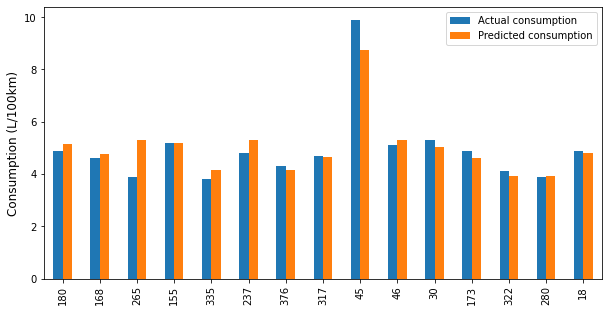

In [38]:
# by taking the 15 of them
df1 = df.sample(15)
display (df1)

#bar plot 
df1.plot(kind='bar',figsize=(10,5))
#plt.grid(which='major', linestyle= '-', linewidth='0.5', color='green')
#plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.ylabel('Consumption (L/100km)', fontsize=12)
plt.show()

# Hypothesis testing

In [4]:
# Hypothesis testing of the mean consumption based on SP98 and E10 (mean consumption comparison)


In [42]:
m1.gas_type.value_counts(dropna=False)

SP98    228
E10     160
Name: gas_type, dtype: int64

In [43]:
m_sp98=m1[m1['gas_type']=='SP98']
m_e10=m1[m1['gas_type']=='E10']

In [44]:
m_sp98.consume.mean()

4.899122807017543

In [45]:
m_e10.consume.mean()

4.931250000000001

In [8]:
#I will test whether the mean consumption (L/100 km) significantly differs between gas type.

# Two-sided test: (test for equality/inequality)
# H0: mean consumption for SP98 = 4.931250000000001 which is = m_e10.consume.mean()
# Alternative hyp or H1: mean age != 4.931250000000001 


/Users/elifyildirim/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


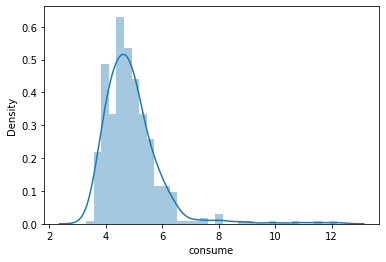

In [41]:
sns.distplot(m1['consume'])
plt.show()

In [46]:
from scipy.stats import ttest_1samp

stat, pval = ttest_1samp(m_sp98['consume'], 4.931250000000001)

In [47]:
print('stat is  ', stat)
print('pvalue for the two-tailed test is ', pval)

stat is   -0.4337504908778175
pvalue for the two-tailed test is  0.6648815703845685


In [13]:
# p value is NOT low. In this case, we fail to reject Ho. There is not enough evidence 
# suggesting that average consumption significantly varies between gas type!


In [48]:
X.columns

Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'gas_type', 'ac',
       'rain', 'sun', 'temp_difference'],
      dtype='object')